In [26]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import sys
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

import glob
from typing import List, Optional
from PIL import Image
from math import log2
from collections import defaultdict, Counter

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


                                          customer_id  \
0   efaafb08a00e63ce561a67c31c1ab7e720d4f394a78c47...   
1   6980555e2eaa19a3f9f8df02e983a8e50abddf6e49cc63...   
2   788785852eddb5874f924603105f315d69571b3e5180f3...   
3   e2731ecc3fb093e25d17348a02a34124c05cd960e9ebd3...   
4   3e8272741c39b3579424da34b2c8b752d2cce5010774d5...   
5   0a45168a9fdde35557e23ab2663ffbd0d565ac380ece7a...   
6   d8c54f5ca6421ba8c5d7631ebdf7a5b67ccf2dce4b859c...   
7   eeff2435dc9b9c1ce597bec9b0266ef4447660800c2a3e...   
8   b174ec45ce78c132071d8267979596ef8eeaf2eeee0e7f...   
9   49841603f3cacf4e7275219dbda875c1226be364466887...   
10  ded9357d33fef6bb884ccb50a40840c4c2d4a27a444b80...   
11  1f5dc0b0f41070e49f55c465318791158aec6dd85b94eb...   
12  d193376eabb7659334edf3536f023197785b321a05774d...   
13  75d3fd5c788fd6f89abdc383ebb5bff31865c830f95008...   
14  49b9854698ccf618a463f0ccfb71288a554062fd42c2ee...   
15  5e03e34f49be37b5166d11775e5fc9e85dfcabe18b48c9...   
16  da0e21de6910c1b9127f867c990

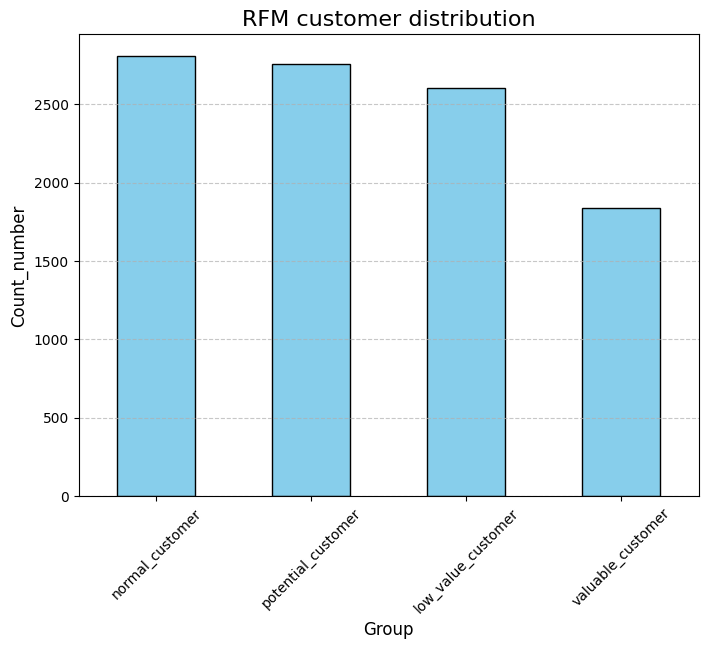

In [27]:
"""Data Management to group different customers."""

input_path = '/content/drive/MyDrive/dissertation/10000_transactions_subset_customers_after20200721_ge6.csv'

df = pd.read_csv(input_path)

grouped_df = (
    df.groupby('customer_id')['article_id']
    .agg([lambda x: ','.join(x.astype(str)),
          'count'])
    .reset_index()
)

grouped_df.columns = ['customer_id', 'article_ids', 'purchase_count']
grouped_df = grouped_df.sort_values(by='purchase_count', ascending=False)

repeat_df = (
    df.groupby(['customer_id', 'article_id'])
    .size()
    .reset_index(name='count')
)

repeat_df = repeat_df[repeat_df['count'] > 5] #repeat purchase > 5

repeat_articles = (
    repeat_df.groupby('customer_id')['article_id']
    .apply(lambda x: ','.join(x.astype(str)))
    .reset_index()
    .rename(columns={'article_id': 'repeated_article_ids'})
)

final_df = grouped_df.merge(repeat_articles, on='customer_id', how='left')

final_df['repeated_article_ids'] = final_df['repeated_article_ids'].fillna('')

total_spent_df = (
    df.groupby('customer_id')['price']
    .sum()
    .reset_index()
    .rename(columns={'price': 'total_spent'})
)

final_df = final_df.merge(total_spent_df, on='customer_id', how='left')

print(final_df.head(20))

df['t_dat'] = pd.to_datetime(df['t_dat'], format='%Y-%m-%d')

analysis_date = df['t_dat'].max() + pd.Timedelta(days=1)

# compute RFM model score:
rfm_df = df.groupby('customer_id').agg({
    't_dat': lambda x: (analysis_date - x.max()).days,  # R: the last day purchased
    'customer_id': 'count',                             # F: how many time purchase
    'price': 'sum'                                      # M: total spent money
}).rename(columns={
    't_dat': 'Recency',
    'customer_id': 'Frequency',
    'price': 'Monetary'
}).reset_index()

rfm_df['R_score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5,4,3,2,1])
rfm_df['F_score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm_df['M_score'] = pd.qcut(rfm_df['Monetary'], 5, labels=[1,2,3,4,5])

rfm_df['RFM_score'] = rfm_df['R_score'].astype(int) + rfm_df['F_score'].astype(int) + rfm_df['M_score'].astype(int)

# print(rfm_df.head(20))

def rfm_segment(row):
    if row['RFM_score'] >= 13:
        return 'valuable_customer'
    elif row['RFM_score'] >= 10:
        return 'potential_customer'
    elif row['RFM_score'] >= 7:
        return 'normal_customer'
    else:
        return 'low_value_customer'

rfm_df['Segment'] = rfm_df.apply(rfm_segment, axis=1)

segment_counts = rfm_df['Segment'].value_counts()

plt.figure(figsize=(8, 6))
segment_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('RFM customer distribution', fontsize=16)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Count_number', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [29]:
"""The single cosine similarity algorithm to generate similar products."""

transactions = pd.read_csv('/content/drive/MyDrive/dissertation/10000_transactions_subset_customers_after20200721_ge6.csv')
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'], errors='coerce')
articles = pd.read_csv('/content/drive/MyDrive/dissertation/articles.csv')
df = transactions.merge(articles, on='article_id', how='left')

CUTOFF_DATE = "2020-07-21"
K = 6

if 'df' not in globals():
    raise RuntimeError("Variable df not exist - please prepare df (transactions merges articles)")


if not np.issubdtype(df['t_dat'].dtype, np.datetime64):
    df['t_dat'] = pd.to_datetime(df['t_dat'], errors='coerce')

#text featuring
text_cols = [
    'product_type_name',
    'colour_group_name',
    'product_group_name',
    'graphical_appearance_name',
]

def row_to_text(row):
    return ' '.join(str(row[c]) if pd.notna(row[c]) else '' for c in text_cols)

if 'item_text' not in df.columns:
    df['item_text'] = df.apply(row_to_text, axis=1).str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()

items = df.drop_duplicates('article_id', keep='first')[['article_id', 'item_text']].reset_index(drop=True)


vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.8, min_df=2)
item_features = vectorizer.fit_transform(items['item_text'])
item_features = normalize(item_features, norm='l2', copy=False)


aid2idx = {aid: i for i, aid in enumerate(items['article_id'].tolist())}
idx2aid = np.array(items['article_id'].tolist())


cutoff_ts = pd.to_datetime(CUTOFF_DATE)
train_df = df[df['t_dat'] < cutoff_ts].dropna(subset=['customer_id','article_id'])

user_groups = train_df.groupby('customer_id')['article_id'].apply(set).to_dict()

def recommend_for_user(user_id, top_n=K, return_scores=False):
    purchased = user_groups.get(user_id, None)
    if not purchased:
        return [] if not return_scores else []

    purchased_idx = [aid2idx[aid] for aid in purchased if aid in aid2idx]
    if not purchased_idx:
        return [] if not return_scores else []

    X = item_features[purchased_idx]              # csr (k, d)
    user_profile = X.sum(axis=0)
    user_profile = np.asarray(user_profile).reshape(1, -1)
    norm = np.linalg.norm(user_profile)
    if norm == 0.0 or not np.isfinite(norm):
        return [] if not return_scores else []
    user_profile = user_profile / norm

    sims = item_features.dot(user_profile.T).ravel() #compute cosine similarity

    k = min(top_n, len(items))
    top_idx_unsorted = np.argpartition(-sims, kth=k-1)[:k]
    top_idx = top_idx_unsorted[np.argsort(-sims[top_idx_unsorted])]

    if return_scores:
        return [(idx2aid[i], float(sims[i])) for i in top_idx]
    else:
        return idx2aid[top_idx].tolist()

train_users = train_df['customer_id'].drop_duplicates().tolist()

records = []
for uid in train_users:
    recs = recommend_for_user(uid, top_n=K, return_scores=False)
    uniq = []
    seen = set()
    for a in recs:
        a = str(a)
        if a not in seen:
            seen.add(a)
            uniq.append(a)
    if len(uniq) < K:
        uniq = uniq + [None] * (K - len(uniq))
    else:
        uniq = uniq[:K]

    row = {'customer_id': uid}
    for i in range(K):
        row[f'rec_{i+1}'] = uniq[i]
    records.append(row)

merged_reco_df = pd.DataFrame.from_records(records)
#store in the merged_reco_df for the evaluation

print(merged_reco_df.head())


                                         customer_id      rec_1      rec_2  \
0  00b85712d5e677f7ae3bfa9f9b5780a6eb328e99aeea63...  929397001  868392002   
1  012bbedf2efe728a7407a5dc842a852f8e09e9ae972711...  712587002  573716002   
2  022d28daa94930566e6139ae25faa966bebd5684cc486c...  814246001  710720004   
3  0246a0d28554496c1214de05bb45de56d41ba29bc356d7...  532138001  859326001   
4  045c56f8b4fe091482792a6c8211dd32a31d10a4463abc...  854780001  827687001   

       rec_3      rec_4      rec_5      rec_6  
0  709178001  618942001  648994006  865921001  
1  783346018  696209002  573716028  712406007  
2  832481002  712216005  821163009  520829003  
3  792436001  816588002  907951001  743722001  
4  716952001  578113002  741430001  485176004  


In [31]:
"""
Evaluation part, three metrics are calculated: Precise, Recall, MAP@6, but the current
results are still not very satisfactory.

The offline evaluation methods have many limitations, online evaluation are essential
in real business environment.
"""

CUTOFF_DATE = "2020-07-21"
K = 6
EXCLUDE_SEEN = True
REQUIRE_TRAIN_AND_TEST = True


if 'df' not in globals():
    raise RuntimeError("Variable df not exist")
if 'merged_reco_df' not in globals():
    raise RuntimeError("Variable merged_reco_df not exist")

need = {'customer_id','article_id','t_dat'}
miss = need - set(df.columns)
if miss:
    raise RuntimeError(f"df lack of attributes: {miss}")

def _norm_aid(a):
    if a is None or (isinstance(a, float) and np.isnan(a)):
        return None
    s = str(a)
    return s[:-2] if s.endswith('.0') else s

def _average_precision_at_k(hit_flags):
    """AP@K: average the precision position."""
    hits, ap = 0, 0.0
    denom = max(1, sum(hit_flags))
    for i, h in enumerate(hit_flags, start=1):
        if h:
            hits += 1
            ap += hits / i
    return ap / denom

df_eval = df.copy()

if not np.issubdtype(df_eval['t_dat'].dtype, np.datetime64):
    df_eval['t_dat'] = pd.to_datetime(df_eval['t_dat'], errors='coerce')

df_eval = df_eval.dropna(subset=['customer_id','article_id','t_dat'])

df_eval['_aid'] = df_eval['article_id'].apply(_norm_aid)
df_eval = df_eval.dropna(subset=['_aid'])

cutoff_ts = pd.to_datetime(CUTOFF_DATE)
train_df = df_eval[df_eval['t_dat'] < cutoff_ts]
test_df  = df_eval[df_eval['t_dat'] >= cutoff_ts]

gt_map = test_df.groupby('customer_id')['_aid'].apply(lambda s: set(s)).to_dict()
seen_map = train_df.groupby('customer_id')['_aid'].apply(lambda s: set(s)).to_dict()

rec_cols = [c for c in merged_reco_df.columns if c.startswith('rec_')]
if not rec_cols:
    raise RuntimeError("no recommendation list in merged_reco_df")

pred_map = {}
for _, r in merged_reco_df[['customer_id'] + rec_cols].drop_duplicates('customer_id').iterrows():
    uid = r['customer_id']
    raw = [_norm_aid(r[c]) for c in rec_cols]
    cleaned, seen = [], set()
    for a in raw:
        if a and a not in seen:
            seen.add(a); cleaned.append(a)
    pred_map[uid] = cleaned[:K]

users_test  = set(gt_map.keys())
users_train = set(seen_map.keys())
users_pred  = set(pred_map.keys())

if REQUIRE_TRAIN_AND_TEST:
    users_eval = sorted(list(users_test & users_train & users_pred))
else:
    users_eval = sorted(list(users_test & users_pred))

precisions, recalls, aps = [], [], []
for uid in users_eval:
    gt_set = gt_map.get(uid, set())
    if not gt_set:
        continue

    preds = pred_map.get(uid, [])

    if EXCLUDE_SEEN:
        preds = [a for a in preds if a not in seen_map.get(uid, set())]

    if not preds:
        continue

    preds = preds[:K]

    hit_flags = [1 if a in gt_set else 0 for a in preds]
    hits = sum(hit_flags)
    effective_k = max(1, min(K, len(preds)))
    precisions.append(hits / effective_k)

    recalls.append(hits / len(gt_set))

    aps.append(_average_precision_at_k(hit_flags))

results = {
    f'Precision@{K}': float(np.mean(precisions)) if precisions else 0.0,
    f'Recall@{K}':    float(np.mean(recalls))    if recalls    else 0.0,
    f'MAP@{K}':       float(np.mean(aps))        if aps        else 0.0,
    'Users_predicted': int(len(users_pred)),
    'Users_in_test':   int(len(users_test)),
    'Users_evaluated': int(len({u for u in users_eval if gt_map.get(u)})),
}

print("=== Evaluation (Precision/Recall/MAP) ===")
for k, v in results.items():
    print(f"{k}: {v:.6f}" if isinstance(v, float) else f"{k}: {v}")


=== Evaluation (Precision/Recall/MAP) ===
Precision@6: 0.001063
Recall@6: 0.000548
MAP@6: 0.002387
Users_predicted: 9285
Users_in_test: 10000
Users_evaluated: 9285


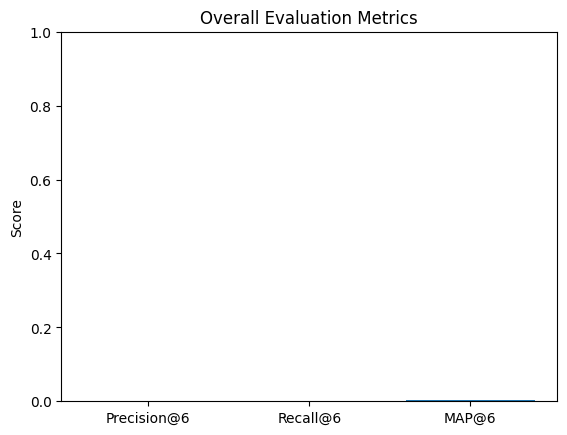

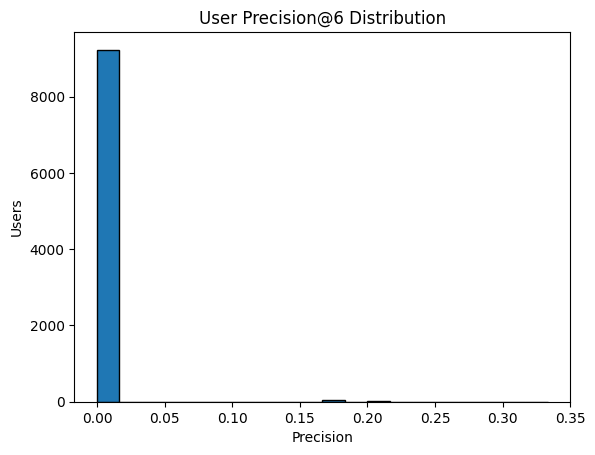

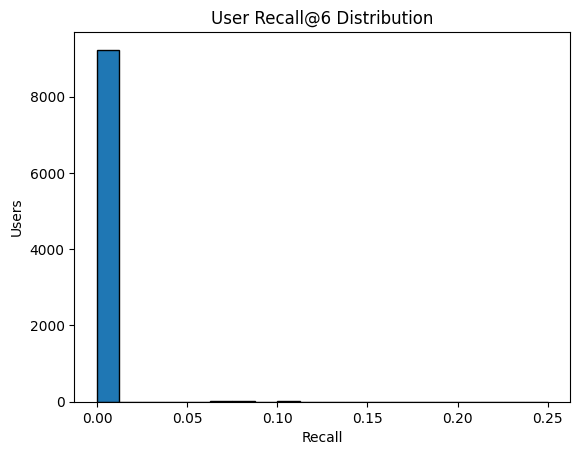

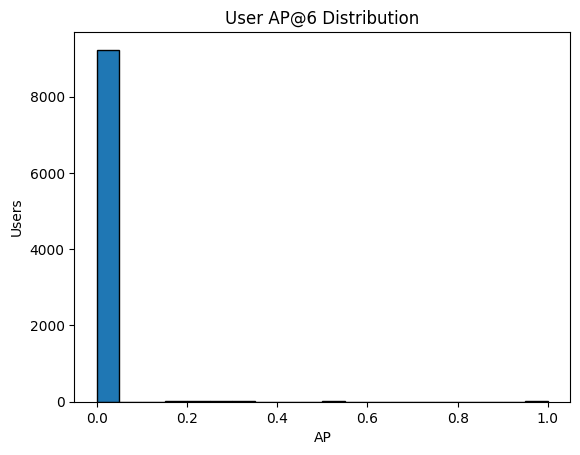

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
metrics_avg = [results[f'Precision@{K}'], results[f'Recall@{K}'], results[f'MAP@{K}']]
labels = [f'Precision@{K}', f'Recall@{K}', f'MAP@{K}']
ax.bar(labels, metrics_avg)
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Overall Evaluation Metrics")
plt.show()

if precisions:
    plt.hist(precisions, bins=20, edgecolor="black")
    plt.title(f"User Precision@{K} Distribution")
    plt.xlabel("Precision"); plt.ylabel("Users")
    plt.show()

if recalls:
    plt.hist(recalls, bins=20, edgecolor="black")
    plt.title(f"User Recall@{K} Distribution")
    plt.xlabel("Recall"); plt.ylabel("Users")
    plt.show()

if aps:
    plt.hist(aps, bins=20, edgecolor="black")
    plt.title(f"User AP@{K} Distribution")
    plt.xlabel("AP"); plt.ylabel("Users")
    plt.show()
